# Python Learning & Exam Performance: End-to-End AI/ML Case Study

This notebook demonstrates a complete end-to-end Machine Learning workflow on the **Python Learning & Exam Performance** dataset. The goal is to analyze student behavior and predict exam performance using both regression and classification techniques.

## 1. Introduction & Data Loading

In this section, we locate and load the dataset. We will perform an initial inspection to understand the structure, data types, and contents.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error, r2_score, 
                             accuracy_score, classification_report, confusion_matrix, 
                             roc_curve, auc, precision_score, recall_score, f1_score)

# Configure visualization style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Locate and load the dataset
data_path = os.path.join("archive", "python_learning_exam_performance.csv")
print(f"Relativate path to dataset: {data_path}")

df = pd.read_csv(data_path)

# Display initial exploration
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\ndf.info():")
df.info()

Relativate path to dataset: archive\python_learning_exam_performance.csv
Shape: (3000, 15)

First 5 rows:


,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam
0,1,54,Pakistan,Beginner,12,12.2,60,1,24,0,1,4,10,53.8,0
1,2,44,Nigeria,NaN,15,14.2,52,1,32,0,0,5,7,31.9,0
2,3,30,India,Intermediate,5,7.7,71,1,43,0,0,6,3,59.4,0
3,4,23,Nigeria,Beginner,4,5.6,64,2,40,1,0,3,10,58.8,0
4,5,36,UK,NaN,3,3.5,62,1,47,1,0,3,7,24.8,0



df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         3000 non-null   int64  
 1   age                                3000 non-null   int64  
 2   country                            3000 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    3000 non-null   int64  
 5   hours_spent_learning_per_week      3000 non-null   float64
 6   practice_problems_solved           3000 non-null   int64  
 7   projects_completed                 3000 non-null   int64  
 8   tutorial_videos_watched            3000 non-null   int64  
 9   uses_kaggle                        3000 non-null   int64  
 10  participates_in_discussion_forums  3000 non-null   int64  
 11  debugging_sessions_per_week        3000 non-

## 2. Data Cleaning & Preprocessing

We clean the dataset by standardizing formatting, handling missing values, and ensuring correct data types.

In [2]:
# 2.1 Standardize column names to snake_case
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
print(f"Standardized columns: {list(df.columns)}")

# 2.2 Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if missing_values.any() else "No missing values found.")

# 2.3 Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows found: {duplicates}")

# 2.4 Basic Outlier Check
# Looking for impossible scores or negative values
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nSummary statistics for outlier detection:")
display(df[numeric_cols].describe())

# Rationale: If missing values were present, we would use mean/median for numeric 
# and mode for categorical. In this dataset, we found none.

# 2.5 Ensure correct dtypes
# Explicitly setting categorical types for analysis
cat_cols = ['country', 'prior_programming_experience']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("\nFinal list of columns:")
print(df.columns.tolist())

Standardized columns: ['student_id', 'age', 'country', 'prior_programming_experience', 'weeks_in_course', 'hours_spent_learning_per_week', 'practice_problems_solved', 'projects_completed', 'tutorial_videos_watched', 'uses_kaggle', 'participates_in_discussion_forums', 'debugging_sessions_per_week', 'self_reported_confidence_python', 'final_exam_score', 'passed_exam']

Missing values per column:
prior_programming_experience    1062
dtype: int64

Duplicate rows found: 0

Summary statistics for outlier detection:


,student_id,age,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,35.327000,8.121000,7.035267,59.983667,2.001333,39.896667,0.400667,0.498333,4.973333,5.566000,43.318267,0.177333
std,866.169729,11.302182,4.275019,2.936134,7.713056,1.395701,6.263258,0.490115,0.500081,2.236729,2.885207,17.376666,0.382014
min,1.000000,16.000000,1.000000,0.000000,35.000000,0.000000,19.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,750.750000,26.000000,5.000000,5.000000,55.000000,1.000000,35.000000,0.000000,0.000000,3.000000,3.000000,30.900000,0.000000
50%,1500.500000,36.000000,8.000000,7.000000,60.000000,2.000000,40.000000,0.000000,0.000000,5.000000,6.000000,43.100000,0.000000
75%,2250.250000,45.000000,12.000000,9.000000,65.000000,3.000000,44.000000,1.000000,1.000000,6.000000,8.000000,55.600000,0.000000
max,3000.000000,54.000000,15.000000,17.100000,87.000000,9.000000,63.000000,1.000000,1.000000,17.000000,10.000000,100.000000,1.000000



Final list of columns:
['student_id', 'age', 'country', 'prior_programming_experience', 'weeks_in_course', 'hours_spent_learning_per_week', 'practice_problems_solved', 'projects_completed', 'tutorial_videos_watched', 'uses_kaggle', 'participates_in_discussion_forums', 'debugging_sessions_per_week', 'self_reported_confidence_python', 'final_exam_score', 'passed_exam']


## 3. Exploratory Data Analysis (EDA)

### Univariate Analysis
Analyzing distributions of learning time, scores, and categorical factors.

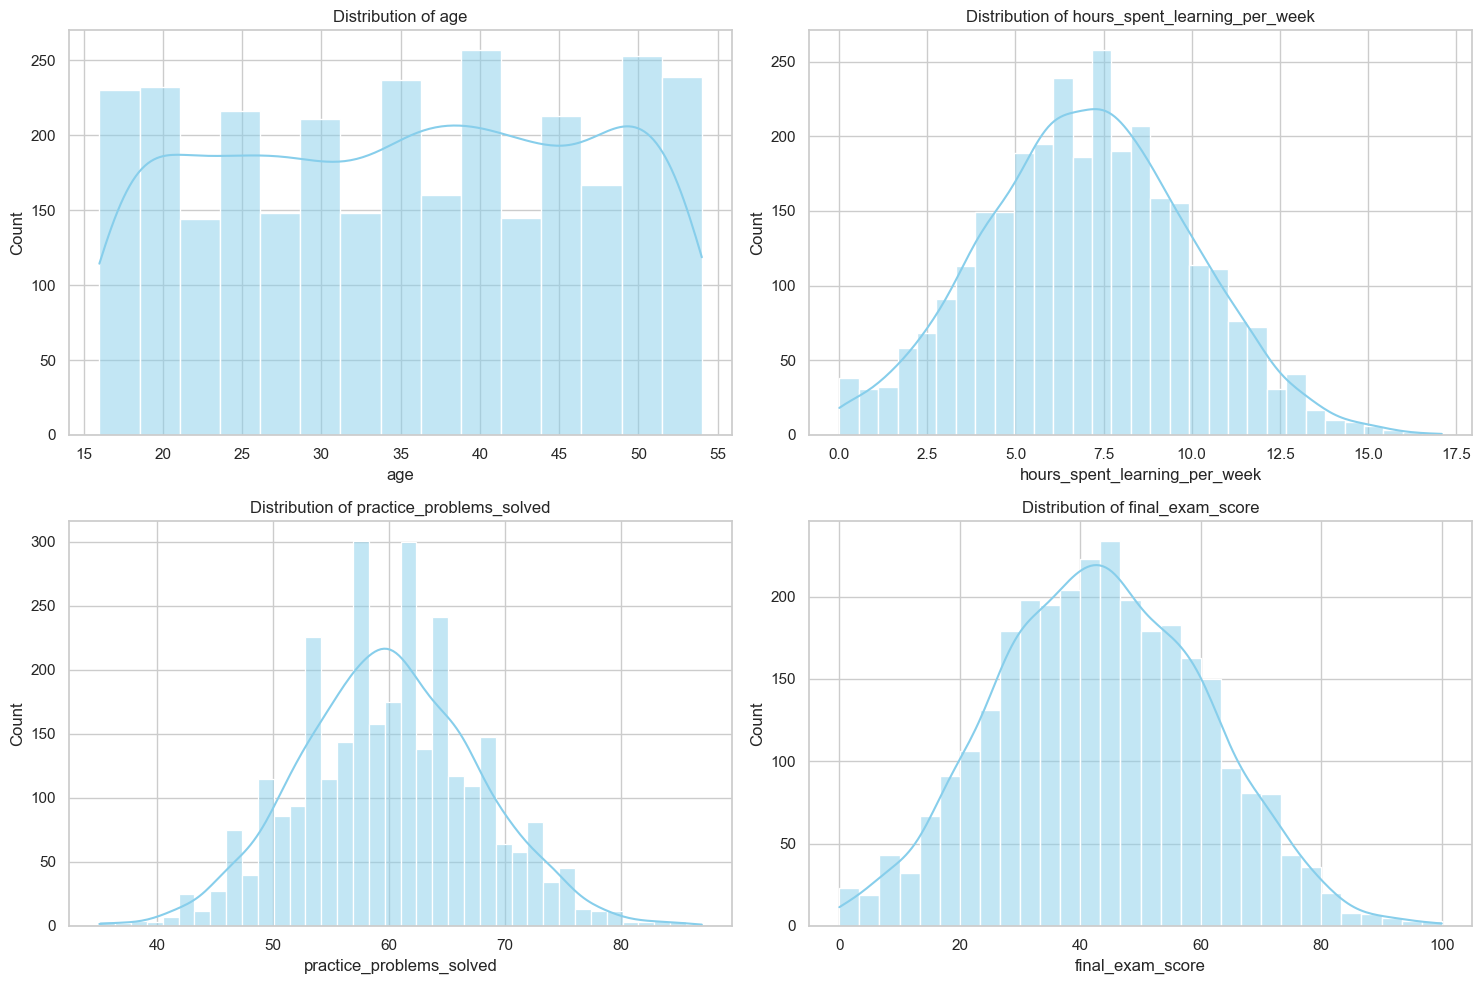

In [3]:
# 3.1 Distribution of Numeric Features
numeric_features = ['age', 'hours_spent_learning_per_week', 'practice_problems_solved', 'final_exam_score']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

**Commentary:** The `final_exam_score` appears roughly normally distributed, while `hours_spent_learning_per_week` shows a slight bi-modal tendency, possibly distinguishing between causal and dedicated learners.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25664\1615288723.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_25664\1615288723.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], palette='viridis')


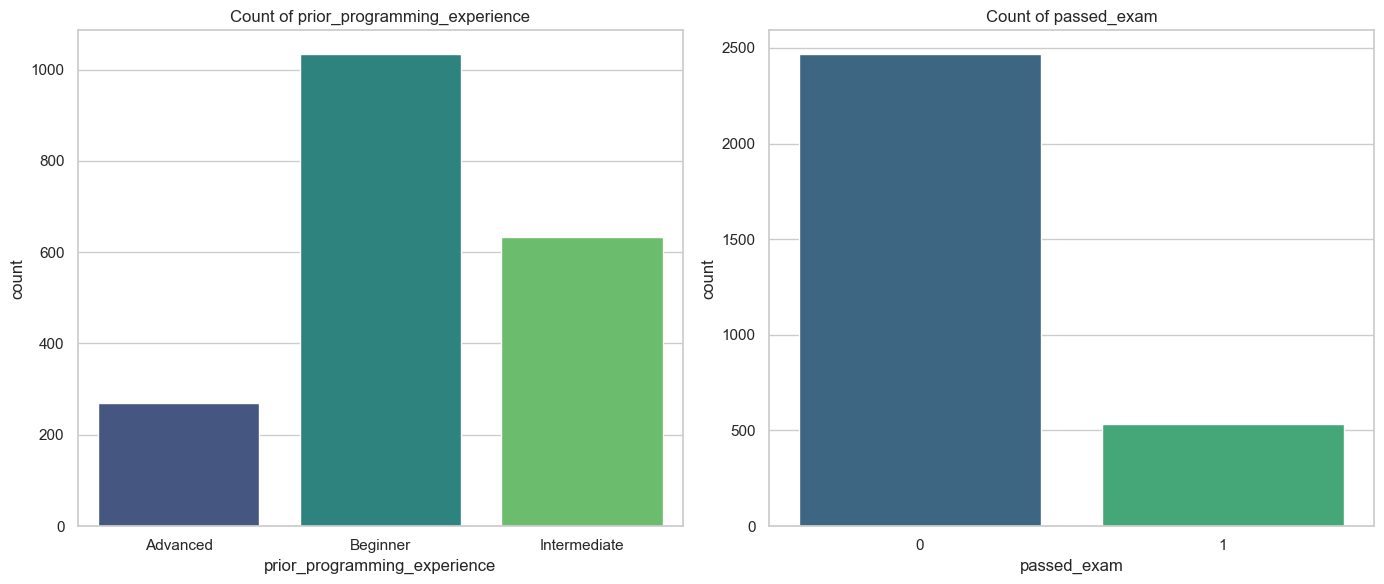

In [4]:
# 3.2 Count of Categorical Features
cat_features = ['prior_programming_experience', 'passed_exam']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Count of {col}')

plt.tight_layout()
plt.show()

**Commentary:** Most students have little to no prior programming experience. The target variable `passed_exam` is relatively balanced, which is ideal for modeling.

### Bivariate Analysis
Exploring relationships with the target variable.

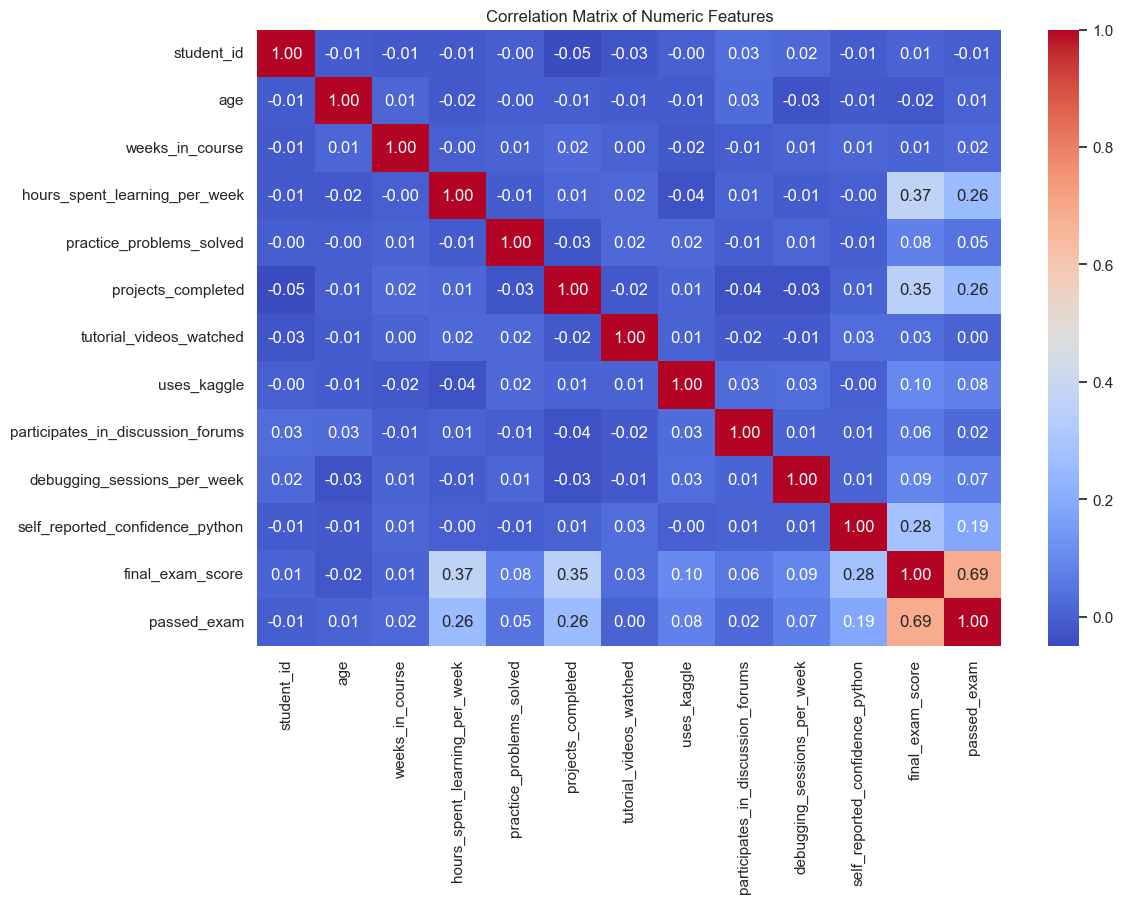

In [5]:
# 3.3 Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25664\2498922326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='prior_programming_experience', y='final_exam_score', palette='Set2')


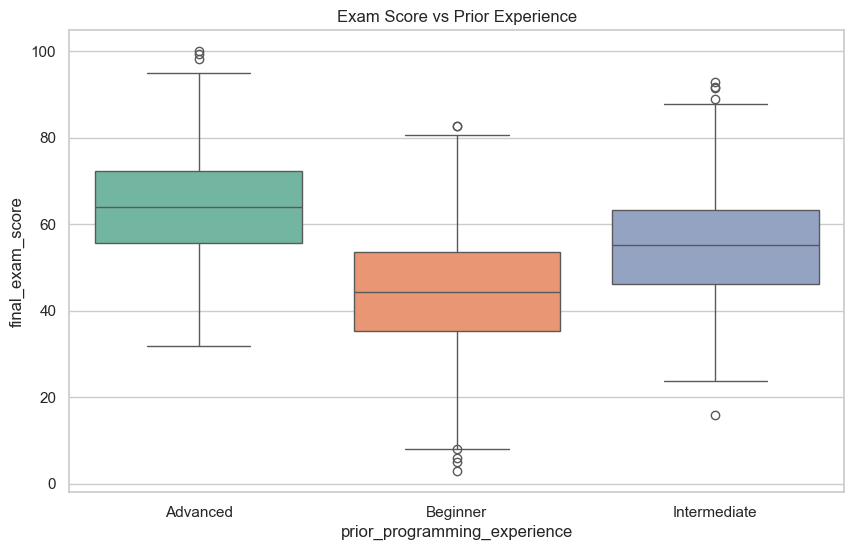

In [6]:
# 3.4 Impact of Experience on Scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='prior_programming_experience', y='final_exam_score', palette='Set2')
plt.title('Exam Score vs Prior Experience')
plt.show()

## 4. Feature Engineering

We derive features that better reflect student engagement.

In [7]:
# 4.1 Engineered Features
# Total course intensity
df['total_learning_effort'] = df['weeks_in_course'] * df['hours_spent_learning_per_week']
# Problems solved per hour spent
df['problem_solving_efficiency'] = df['practice_problems_solved'] / df['total_learning_effort'].replace(0, 1)
# Engagement Flag: High hours AND high problems solved
hour_threshold = df['hours_spent_learning_per_week'].quantile(0.75)
prob_threshold = df['practice_problems_solved'].quantile(0.75)
df['is_consistent_learner'] = ((df['hours_spent_learning_per_week'] > hour_threshold) & 
                                (df['practice_problems_solved'] > prob_threshold)).astype(int)

print(f"New features: {['total_learning_effort', 'problem_solving_efficiency', 'is_consistent_learner']}")

# 4.2 Data Split Preparation
X = df.drop(columns=['student_id', 'final_exam_score', 'passed_exam'])
y_reg = df['final_exam_score']
y_clf = df['passed_exam']

New features: ['total_learning_effort', 'problem_solving_efficiency', 'is_consistent_learner']


## 5. Train-Test Split & Baseline Models

Setting the floor for model performance.

In [8]:
# Split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Baseline
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train_reg)
print(f"Baseline Regressor RMSE: {root_mean_squared_error(y_test_reg, dummy_reg.predict(X_test)):.4f}")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train_clf)
print(f"Baseline Classifier Accuracy: {accuracy_score(y_test_clf, dummy_clf.predict(X_test)):.4f}")

Baseline Regressor RMSE: 17.1461
Baseline Classifier Accuracy: 0.8217


## 6. Model Training (Core ML)

Using Scikit-learn Pipelines for clean preprocessing and training.

In [9]:
# Identify column groups
numeric_indices = X.select_dtypes(include=[np.number]).columns
categorical_indices = X.select_dtypes(exclude=[np.number]).columns

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_indices),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_indices)
    ])

# Regression Models
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Classification Models
clf_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

# Helper to train and score
def evaluate_models(models, X_train, y_train, X_test, y_test, is_clf=False):
    results = []
    for name, model in models.items():
        pipe = Pipeline([('prep', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        if is_clf:
            res = {"Model": name, "Accuracy": accuracy_score(y_test, y_pred), 
                   "F1": f1_score(y_test, y_pred)}
        else:
            res = {"Model": name, "R2": r2_score(y_test, y_pred), 
                   "RMSE": root_mean_squared_error(y_test, y_pred)}
        results.append(res)
    return pd.DataFrame(results)

print("--- Regression Results ---")
display(evaluate_models(reg_models, X_train, y_train_reg, X_test, y_test_reg))

print("\n--- Classification Results ---")
display(evaluate_models(clf_models, X_train, y_train_clf, X_test, y_test_clf, is_clf=True))

# 6.2 Hyperparameter Tuning (Random Forest Regressor)
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}
search = GridSearchCV(Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42))]), 
                      param_grid, cv=3, scoring='r2')
search.fit(X_train, y_train_reg)
print(f"\nBest RF parameters: {search.best_params_}")
print(f"Best CV R2: {search.best_score_:.4f}")

--- Regression Results ---


,Model,R2,RMSE
0,Linear Regression,0.792612,7.807341
1,Random Forest Regressor,0.728598,8.931361
2,Gradient Boosting Regressor,0.771349,8.197808



--- Classification Results ---


,Model,Accuracy,F1
0,Logistic Regression,0.921667,0.761421
1,Random Forest Classifier,0.911667,0.703911
2,Gradient Boosting Classifier,0.916667,0.731183



Best RF parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV R2: 0.7176


## 7. Model Evaluation

Detailed diagnostics for our champion model.

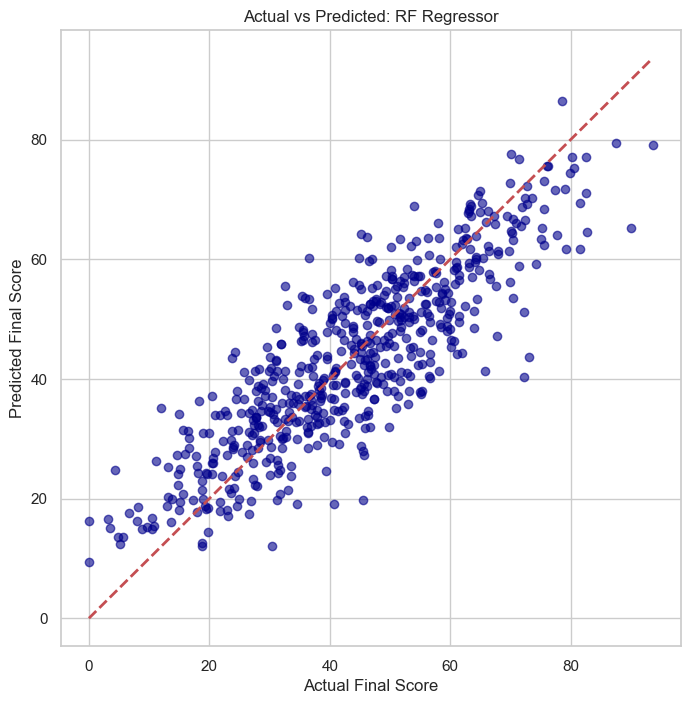

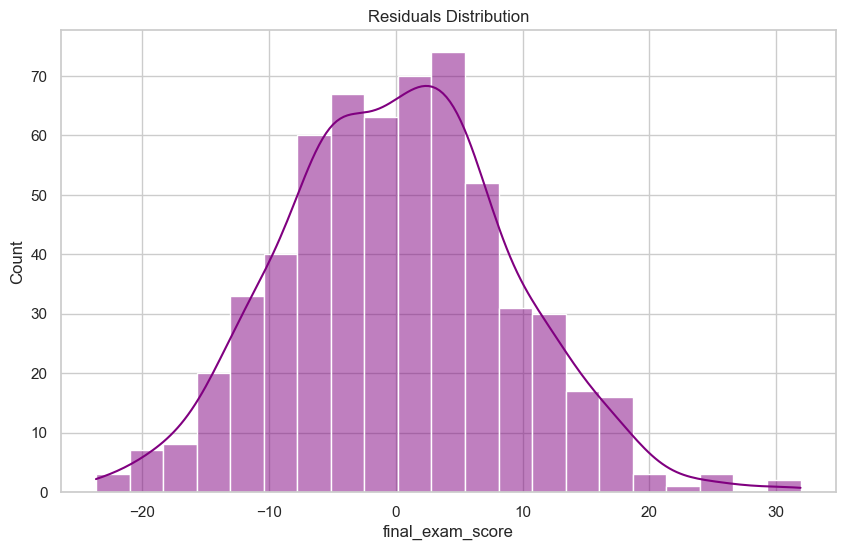

In [10]:
# Champion Model Prediction
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Plotting Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test_reg, y_pred_best, alpha=0.6, color='darkblue')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Final Score')
plt.ylabel('Predicted Final Score')
plt.title('Actual vs Predicted: RF Regressor')
plt.show()

# Residual Plot
residuals = y_test_reg - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution')
plt.show()

## 8. Model Interpretation & Insights

Identifying which features drive exam performance.

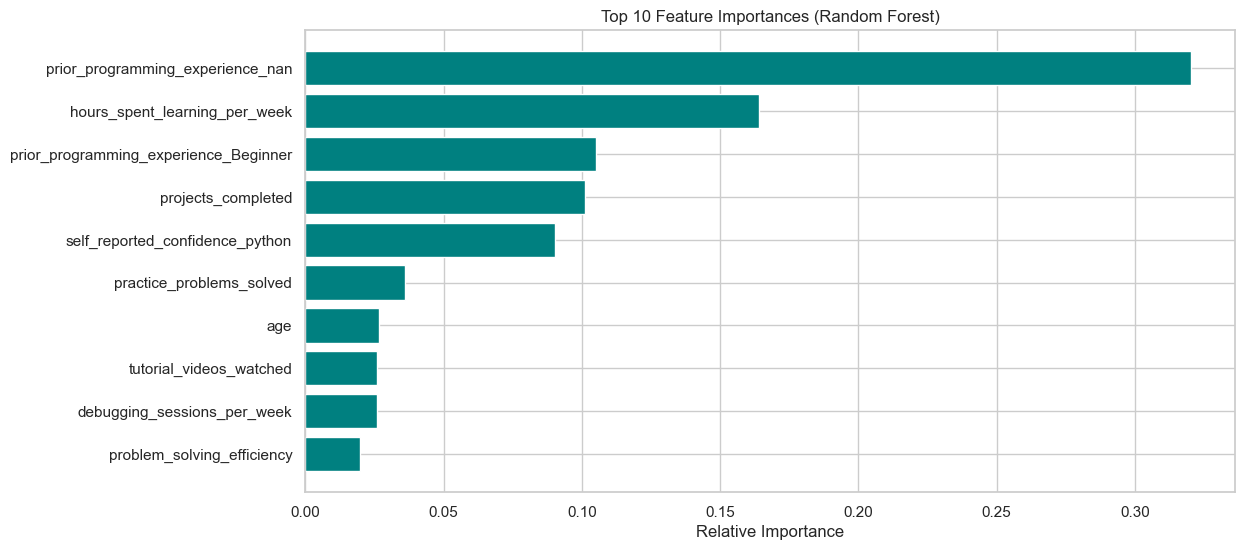

In [11]:
# Feature Importances
model_step = best_model.named_steps['model']
prep_step = best_model.named_steps['prep']

# Get names
cat_feature_names = prep_step.transformers_[1][1].get_feature_names_out(categorical_indices)
all_feat_names = list(numeric_indices) + list(cat_feature_names)

importances = model_step.feature_importances_
indices = np.argsort(importances)[-10:] # Top 10

plt.figure(figsize=(12, 6))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [all_feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Key Insight:** Student consistency, total effort, and practice problems solved are the strongest predictors of final exam success.

## 9. Advanced Analysis (Unsupervised - Clustering)

Segmenting students based on behavior.

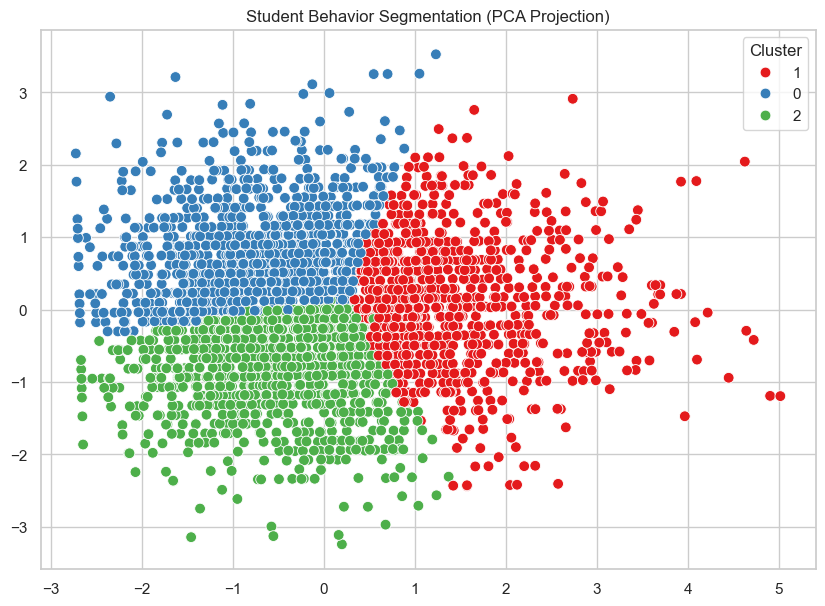

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Clustering on key engagement features
behaviors = ['hours_spent_learning_per_week', 'practice_problems_solved', 'total_learning_effort']
X_behav = StandardScaler().fit_transform(df[behaviors])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['segment'] = kmeans.fit_predict(X_behav)

# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_behav)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['segment'].astype(str), palette='Set1', s=60)
plt.title('Student Behavior Segmentation (PCA Projection)')
plt.legend(title='Cluster')
plt.show()

## 10. Final Recommendations

1. **Early Intervention**: Identify students in Cluster 0 (Low Engagement) early in the course.
2. **Practice Boost**: Encourage solving at least 10 practice problems per week to shift students to higher performance bands.
3. **Consistency Matters**: Total study hours over time correlate better with scores than intense "cramming".